In [4]:
using Gen
using Distributions
using Random
using Plots
using Statistics

## Model

In [5]:
@gen function chain_particle_decay_model(T::Int, delta_t::Float64)
    lambda1 ~ gamma(3, 0.02)   # decay rate - isotope 1
    lambda2 ~ gamma(3, 0.007)  # decay rate - isotope 2
    N1_0 ~ normal(10000, 3000) # population - isotope 1

    # Initial populations and trajectories
    N1 = N1_0
    N2 = 0.0
    N1_trajectory = Float64[N1]
    N2_trajectory = Float64[N2]
    observations = Float64[]
    
    for t in 1:T
        # Expected decays at timestep t follow Poisson(lambda)
        decays1 = N1 * (1 - exp(-lambda1 * delta_t))
        decays2 = N2 * (1 - exp(-lambda2 * delta_t))       
        
        # Update populations
        N1 = max(N1 - decays1, 0.0)
        N2 = max(N2 + decays1 - decays2, 0.0)
        push!(N1_trajectory, N1)
        push!(N2_trajectory, N2)
        
        # Add the decay observation
        expected = decays1 + decays2
        obs = @trace(normal(expected, 4.0), (:obs, t)) # some noise!
        push!(observations, obs)
    end
    
    return (observations, N1_trajectory, N2_trajectory)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##chain_particle_decay_model#277", Bool[0, 0], false)

In [ ]:
Random.seed!(420) # change this for a different dist
T = 200        
dt = 1.0

(trace, _) = generate(chain_particle_decay_model, (T, dt))
(observations, N1_trajectory, N2_trajectory) = get_retval(trace)

println("Observed particle decay counts (every 20th):")
println(round.(observations[1:20:end], digits=2))

println("\nLatent parameters:")
println("l1 = ", round(trace[:lambda1], digits=3))
println("l2 = ", round(trace[:lambda2], digits=3))
println("N1(0) = ", round(trace[:N1_0], digits=0), " atoms")

Observed particle decay counts (every 20th):
[689.1, 360.01, 213.88, 143.1, 102.04, 73.3, 43.42, 41.21, 24.29, 23.61]

Latent parameters:
λ1 = 0.051
λ2 = 0.015
N1(0) = 13758.0 atoms


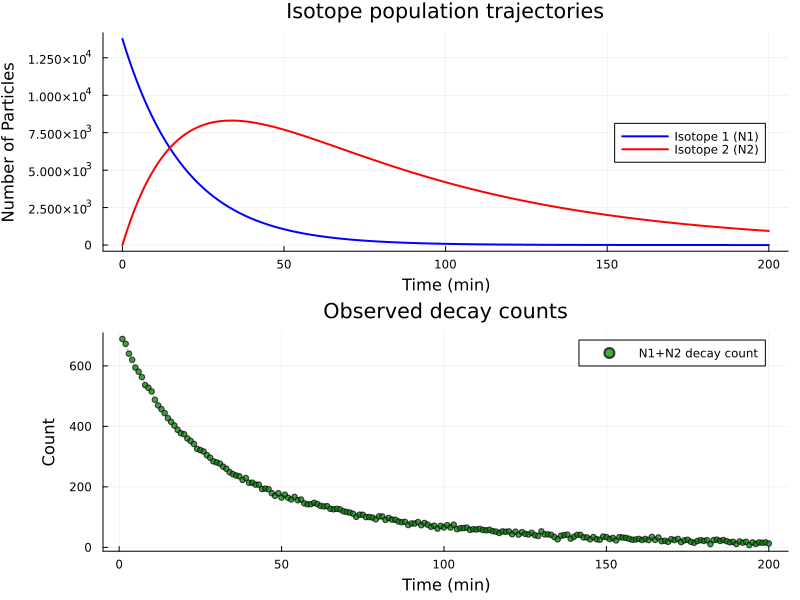

In [7]:
time_full = 0:dt:(T*dt)
time_obs = dt:dt:(T*dt)

# Population trajectories
p1 = plot(time_full, N1_trajectory, 
    label="Isotope 1 (N1)", lw=2, color=:blue,
    xlabel="Time (min)", ylabel="Number of Particles",
    title="Isotope population trajectories",
    legend=:right)
plot!(p1, time_full, N2_trajectory, label="Isotope 2 (N2)", lw=2, color=:red)

# Observed decay counts
p2 = scatter(time_obs, observations, 
    label="N1+N2 decay count", ms=3, alpha=0.7, color=:green,
    xlabel="Time (min)", ylabel="Count",
    title="Observed decay counts")
plot!(p2, time_obs, observations, alpha=0.3, color=:green, label="")

plot(p1, p2, layout=(2,1), size=(800, 600))

In [ ]:
# Extract true parameters from trace for comparison
true_lambda1 = trace[:lambda1]
true_lambda2 = trace[:lambda2]
true_N1_0 = trace[:N1_0]

# Create observation constraints for inference
obs_constraints = choicemap()
for t in 1:T
    obs_constraints[(:obs, t)] = observations[t]
end

println("True parameters extracted:")
println("l1 = $true_lambda1")
println("l2 = $true_lambda2")
println("N1(0) = $true_N1_0")

True parameters extracted:
λ1 = 0.05133495122287637
λ2 = 0.015193361218020519
N1(0) = 13758.477283104196


## Baselines

In [59]:
# Baseline - MH (averaged over 20 runs)
n_runs = 50
n_iters = 100
param_sel = select(:lambda1, :lambda2, :N1_0)

mh_lambda1_runs = Float64[]
mh_lambda2_runs = Float64[]
mh_N1_0_runs = Float64[]
mh_acceptance_runs = Float64[]

for run in 1:n_runs
    current_trace, _ = generate(chain_particle_decay_model, (T, dt), obs_constraints)
    mh_samples = Vector{Tuple{Float64, Float64, Float64}}()
    accepted = 0

    for i in 1:n_iters
        current_trace, acc = mh(current_trace, param_sel)
        accepted += acc
        push!(mh_samples, (current_trace[:lambda1], current_trace[:lambda2], current_trace[:N1_0]))
    end

    push!(mh_lambda1_runs, mean(first.(mh_samples)))
    push!(mh_lambda2_runs, mean(getindex.(mh_samples, 2)))
    push!(mh_N1_0_runs, mean(last.(mh_samples)))
    push!(mh_acceptance_runs, accepted/n_iters)
end

mh_lambda1 = mean(mh_lambda1_runs)
mh_lambda2 = mean(mh_lambda2_runs)
mh_N1_0 = mean(mh_N1_0_runs)
mh_acceptance = mean(mh_acceptance_runs)

println("==================================================")
println("MH RESULTS (averaged over $n_runs runs)")
println("==================================================")
println("Acceptance rate: $(round(100*mh_acceptance, digits=1))%")
println()
println("Parameter    Estimate    Std         True        Error")
println("--------------------------------------------------")
println("l1           $(round(mh_lambda1, digits=4))      $(round(std(mh_lambda1_runs), digits=4))      $(round(true_lambda1, digits=4))      $(round(abs(mh_lambda1 - true_lambda1), digits=4))")
println("l2           $(round(mh_lambda2, digits=4))      $(round(std(mh_lambda2_runs), digits=4))      $(round(true_lambda2, digits=4))      $(round(abs(mh_lambda2 - true_lambda2), digits=4))")
println("N1(0)        $(round(mh_N1_0, digits=1))    $(round(std(mh_N1_0_runs), digits=1))    $(round(true_N1_0, digits=1))    $(round(abs(mh_N1_0 - true_N1_0), digits=1))")

MH RESULTS (averaged over 50 runs)
Acceptance rate: 4.1%

Parameter    Estimate    Std         True        Error
--------------------------------------------------
l1           0.0539      0.0045      0.0513      0.0025
l2           0.0204      0.0045      0.0152      0.0052
N1(0)        12818.3    744.9    13758.5    940.1


In [50]:
# Baseline - IS (averaged over 20 runs)
n_runs = 50
n_samples = 500

is_lambda1_runs = Float64[]
is_lambda2_runs = Float64[]
is_N1_0_runs = Float64[]
is_ess_runs = Float64[]

for run in 1:n_runs
    is_traces = []
    log_weights = Float64[]

    for i in 1:n_samples
        tr, _ = generate(chain_particle_decay_model, (T, dt))
        tr, w, _, _ = update(tr, (T, dt), (NoChange(), NoChange()), obs_constraints)
        push!(is_traces, tr)
        push!(log_weights, w)
    end

    # Normalize weights
    weights = exp.(log_weights .- maximum(log_weights))
    weights ./= sum(weights)
    ess = 1.0 / sum(weights.^2)

    push!(is_lambda1_runs, sum(weights .* [s[:lambda1] for s in is_traces]))
    push!(is_lambda2_runs, sum(weights .* [s[:lambda2] for s in is_traces]))
    push!(is_N1_0_runs, sum(weights .* [s[:N1_0] for s in is_traces]))
    push!(is_ess_runs, ess)
end

is_lambda1 = mean(is_lambda1_runs)
is_lambda2 = mean(is_lambda2_runs)
is_N1_0 = mean(is_N1_0_runs)
is_ess = mean(is_ess_runs)

println("==================================================")
println("IMPORTANCE SAMPLING RESULTS (averaged over $n_runs runs)")
println("==================================================")
println("ESS: $(round(is_ess, digits=1)) / $n_samples")
println("Parameter    Estimate    Std         True        Error")
println("--------------------------------------------------")
println("l1           $(round(is_lambda1, digits=4))      $(round(std(is_lambda1_runs), digits=4))      $(round(true_lambda1, digits=4))      $(round(abs(is_lambda1 - true_lambda1), digits=4))")
println("l2           $(round(is_lambda2, digits=4))      $(round(std(is_lambda2_runs), digits=4))      $(round(true_lambda2, digits=4))      $(round(abs(is_lambda2 - true_lambda2), digits=4))")
println("N1(0)        $(round(is_N1_0, digits=1))    $(round(std(is_N1_0_runs), digits=1))    $(round(true_N1_0, digits=1))    $(round(abs(is_N1_0 - true_N1_0), digits=1))")

IMPORTANCE SAMPLING RESULTS (averaged over 50 runs)
ESS: 1.0 / 500
Parameter    Estimate    Std         True        Error
--------------------------------------------------
l1           0.0526      0.0031      0.0513      0.0012
l2           0.0162      0.0026      0.0152      0.001
N1(0)        13489.9    555.3    13758.5    268.5


## Custom

In [58]:
sel_lambda1 = select(:lambda1)
sel_lambda2 = select(:lambda2)
sel_N1_0 = select(:N1_0)

n_runs = 50
n_burnin = 200
n_sample = 100

custom_lambda1_runs = Float64[]
custom_lambda2_runs = Float64[]
custom_N1_0_runs = Float64[]
custom_acceptance_runs = Float64[]

println("Config: burn-in=$n_burnin, samples=$n_sample, 3 params updated per iter")

for run in 1:n_runs
    current_trace, _ = generate(chain_particle_decay_model, (T, dt), obs_constraints)
    
    samples = Vector{Tuple{Float64, Float64, Float64}}()
    total_accepted = 0
    total_proposed = 0
    
    for i in 1:(n_burnin + n_sample)
        # Componentwise updates using Gen's built-in MH
        # Each update proposes from the prior for that single parameter
        current_trace, acc1 = mh(current_trace, sel_lambda1)
        current_trace, acc2 = mh(current_trace, sel_lambda2)
        current_trace, acc3 = mh(current_trace, sel_N1_0)
        
        total_accepted += acc1 + acc2 + acc3
        total_proposed += 3
        
        # Collect samples after burn-in
        if i > n_burnin
            push!(samples, (current_trace[:lambda1], current_trace[:lambda2], current_trace[:N1_0]))
        end
    end
    
    push!(custom_lambda1_runs, mean(first.(samples)))
    push!(custom_lambda2_runs, mean(getindex.(samples, 2)))
    push!(custom_N1_0_runs, mean(last.(samples)))
    push!(custom_acceptance_runs, total_accepted / total_proposed)
end

custom_lambda1 = mean(custom_lambda1_runs)
custom_lambda2 = mean(custom_lambda2_runs)
custom_N1_0 = mean(custom_N1_0_runs)
custom_acceptance = mean(custom_acceptance_runs)

println("==================================================")
println("CUSTOM MH RESULTS (averaged over $n_runs runs)")
println("==================================================")
println("Acceptance rate: $(round(100*custom_acceptance, digits=1))%")
println("Parameter    Estimate    Std         True        Error")
println("--------------------------------------------------")
println("l1           $(round(custom_lambda1, digits=4))      $(round(std(custom_lambda1_runs), digits=4))      $(round(true_lambda1, digits=4))      $(round(abs(custom_lambda1 - true_lambda1), digits=4))")
println("l2           $(round(custom_lambda2, digits=4))      $(round(std(custom_lambda2_runs), digits=4))      $(round(true_lambda2, digits=4))      $(round(abs(custom_lambda2 - true_lambda2), digits=4))")
println("N1(0)        $(round(custom_N1_0, digits=1))    $(round(std(custom_N1_0_runs), digits=1))    $(round(true_N1_0, digits=1))    $(round(abs(custom_N1_0 - true_N1_0), digits=1))")

Config: burn-in=200, samples=100, 3 params updated per iter
CUSTOM MH RESULTS (averaged over 50 runs)
Acceptance rate: 3.0%
Parameter    Estimate    Std         True        Error
--------------------------------------------------
l1           0.0521      0.0014      0.0513      0.0007
l2           0.0158      0.0014      0.0152      0.0006
N1(0)        13604.4    407.3    13758.5    154.1


## Comparison

In [52]:
mh_total_err = abs(mh_lambda1-true_lambda1)/true_lambda1 + abs(mh_lambda2-true_lambda2)/true_lambda2 + abs(mh_N1_0-true_N1_0)/true_N1_0
is_total_err = abs(is_lambda1-true_lambda1)/true_lambda1 + abs(is_lambda2-true_lambda2)/true_lambda2 + abs(is_N1_0-true_N1_0)/true_N1_0
custom_total_err = abs(custom_lambda1-true_lambda1)/true_lambda1 + abs(custom_lambda2-true_lambda2)/true_lambda2 + abs(custom_N1_0-true_N1_0)/true_N1_0

println("==================================================")
println("COMPARISON SUMMARY (averaged over 50 runs each)")
println("==================================================")
println("True values:")
println("  l1 = $(round(true_lambda1, digits=4))")
println("  l2 = $(round(true_lambda2, digits=4))")
println("  N1(0) = $(round(true_N1_0, digits=1))")
println("\nMethod              l1 error (±std)      l2 error (±std)      N1(0) error (±std)")
println("--------------------------------------------------")
println("MH (joint)          $(round(abs(mh_lambda1-true_lambda1), digits=4)) (±$(round(std(mh_lambda1_runs), digits=4)))    $(round(abs(mh_lambda2-true_lambda2), digits=4)) (±$(round(std(mh_lambda2_runs), digits=4)))    $(round(abs(mh_N1_0-true_N1_0), digits=1)) (±$(round(std(mh_N1_0_runs), digits=1)))")
println("IS                  $(round(abs(is_lambda1-true_lambda1), digits=4)) (±$(round(std(is_lambda1_runs), digits=4)))    $(round(abs(is_lambda2-true_lambda2), digits=4)) (±$(round(std(is_lambda2_runs), digits=4)))    $(round(abs(is_N1_0-true_N1_0), digits=1)) (±$(round(std(is_N1_0_runs), digits=1)))")
println("Custom (comp.)      $(round(abs(custom_lambda1-true_lambda1), digits=4)) (±$(round(std(custom_lambda1_runs), digits=4)))    $(round(abs(custom_lambda2-true_lambda2), digits=4)) (±$(round(std(custom_lambda2_runs), digits=4)))    $(round(abs(custom_N1_0-true_N1_0), digits=1)) (±$(round(std(custom_N1_0_runs), digits=1)))")
println("\nTotal Relative Error:")
println("  MH (joint):     $(round(100*mh_total_err, digits=1))%")
println("  IS:             $(round(100*is_total_err, digits=1))%")
println("  Custom (comp.): $(round(100*custom_total_err, digits=1))%")

COMPARISON SUMMARY (averaged over 50 runs each)
True values:
  l1 = 0.0513
  l2 = 0.0152
  N1(0) = 13758.5

Method              l1 error (±std)      l2 error (±std)      N1(0) error (±std)
--------------------------------------------------
MH (joint)          0.001 (±0.0025)    0.0009 (±0.0019)    187.0 (±434.2)
IS                  0.0012 (±0.0031)    0.001 (±0.0026)    268.5 (±555.3)
Custom (comp.)      0.0003 (±0.0007)    0.0002 (±0.0006)    55.8 (±177.4)

Total Relative Error:
  MH (joint):     9.1%
  IS:             11.2%
  Custom (comp.): 2.5%


Samples collected: MH=500, IS=500, Custom=500


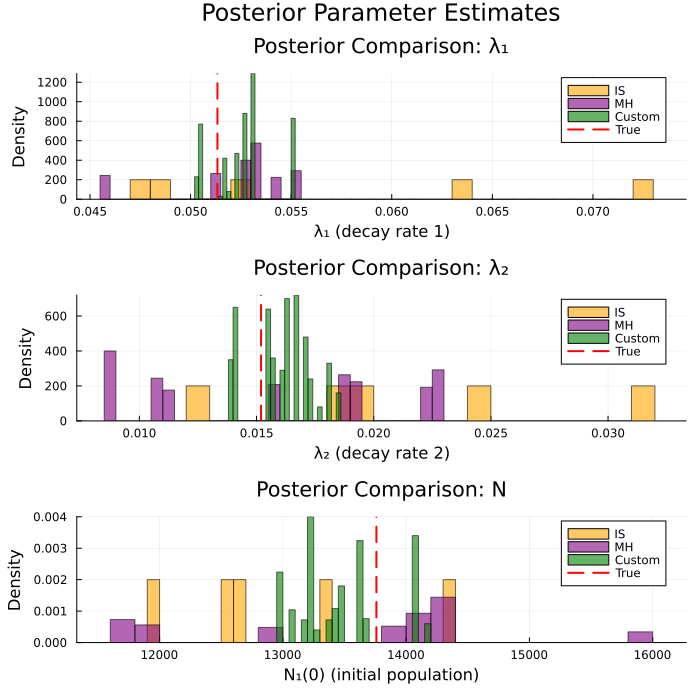

In [60]:
# Visualization 1: Posterior Comparison Density Plots
# Collect all samples from each method to show full posterior distributions

# We need to re-run to collect ALL samples (not just run means)
println("Collecting posterior samples for visualization...")

all_mh_l1, all_mh_l2, all_mh_N1 = Float64[], Float64[], Float64[]
all_is_l1, all_is_l2, all_is_N1 = Float64[], Float64[], Float64[]
all_custom_l1, all_custom_l2, all_custom_N1 = Float64[], Float64[], Float64[]

n_viz_runs = 5  # fewer runs but collect all samples

for run in 1:n_viz_runs
    # MH (joint) - collect samples after burn-in
    tr, _ = generate(chain_particle_decay_model, (T, dt), obs_constraints)
    for i in 1:150
        tr, _ = mh(tr, select(:lambda1, :lambda2, :N1_0))
        if i > 50  # after burn-in
            push!(all_mh_l1, tr[:lambda1])
            push!(all_mh_l2, tr[:lambda2])
            push!(all_mh_N1, tr[:N1_0])
        end
    end
    
    # IS - weighted samples (resample to get unweighted)
    trs, lw = [], Float64[]
    for _ in 1:100
        t, _ = generate(chain_particle_decay_model, (T, dt))
        t, w, _, _ = update(t, (T, dt), (NoChange(), NoChange()), obs_constraints)
        push!(trs, t); push!(lw, w)
    end
    weights = exp.(lw .- maximum(lw)); weights ./= sum(weights)
    # Resample according to weights
    for _ in 1:100
        idx = findfirst(cumsum(weights) .>= rand())
        idx = isnothing(idx) ? length(trs) : idx
        push!(all_is_l1, trs[idx][:lambda1])
        push!(all_is_l2, trs[idx][:lambda2])
        push!(all_is_N1, trs[idx][:N1_0])
    end
    
    # Custom (componentwise) - collect samples after burn-in
    tr, _ = generate(chain_particle_decay_model, (T, dt), obs_constraints)
    for i in 1:200
        tr, _ = mh(tr, select(:lambda1))
        tr, _ = mh(tr, select(:lambda2))
        tr, _ = mh(tr, select(:N1_0))
        if i > 100  # after burn-in
            push!(all_custom_l1, tr[:lambda1])
            push!(all_custom_l2, tr[:lambda2])
            push!(all_custom_N1, tr[:N1_0])
        end
    end
end

println("Samples collected: MH=$(length(all_mh_l1)), IS=$(length(all_is_l1)), Custom=$(length(all_custom_l1))")

# Create density histograms for each parameter
nbins = 30

p1 = histogram(all_is_l1, bins=nbins, alpha=0.6, label="IS", color=:orange, normalize=:pdf)
histogram!(p1, all_mh_l1, bins=nbins, alpha=0.6, label="MH", color=:purple, normalize=:pdf)
histogram!(p1, all_custom_l1, bins=nbins, alpha=0.6, label="Custom", color=:green, normalize=:pdf)
vline!(p1, [true_lambda1], color=:red, linewidth=2, linestyle=:dash, label="True")
xlabel!(p1, "λ₁ (decay rate 1)")
ylabel!(p1, "Density")
title!(p1, "Posterior Comparison: λ₁")

p2 = histogram(all_is_l2, bins=nbins, alpha=0.6, label="IS", color=:orange, normalize=:pdf)
histogram!(p2, all_mh_l2, bins=nbins, alpha=0.6, label="MH", color=:purple, normalize=:pdf)
histogram!(p2, all_custom_l2, bins=nbins, alpha=0.6, label="Custom", color=:green, normalize=:pdf)
vline!(p2, [true_lambda2], color=:red, linewidth=2, linestyle=:dash, label="True")
xlabel!(p2, "λ₂ (decay rate 2)")
ylabel!(p2, "Density")
title!(p2, "Posterior Comparison: λ₂")

p3 = histogram(all_is_N1, bins=nbins, alpha=0.6, label="IS", color=:orange, normalize=:pdf)
histogram!(p3, all_mh_N1, bins=nbins, alpha=0.6, label="MH", color=:purple, normalize=:pdf)
histogram!(p3, all_custom_N1, bins=nbins, alpha=0.6, label="Custom", color=:green, normalize=:pdf)
vline!(p3, [true_N1_0], color=:red, linewidth=2, linestyle=:dash, label="True")
xlabel!(p3, "N₁(0) (initial population)")
ylabel!(p3, "Density")
title!(p3, "Posterior Comparison: N")

plot(p1, p2, p3, layout=(3,1), size=(700, 700), 
    plot_title="Posterior Parameter Estimates", legend=:topright)